In [1]:
import matplotlib.pyplot as plt
import torch
import pytorch3d
import numpy as np

from ray_sampling import RaySampler
from point_sampling import sample_along_camera_ray

from co3d.dataset.dataset_zoo import dataset_zoo
from co3d.dataset.dataloader_zoo import dataloader_zoo

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [3]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )

set_names_mapping :{'train': ['test_known'], 'val': ['test_known', 'test_unseen'], 'test': ['test_known', 'test_unseen']}
Dataset :  train
subsets :  ['test_known']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Dataset :  val
subsets :  ['test_known', 'test_unseen']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subset

In [4]:
dataloaders = dataloader_zoo(
        datasets,
        dataset_name=f"co3d_{task}",
    )

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

dataset_set : train, dataset : CO3D Dataset #frames=81, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]
dataset_set : val, dataset : CO3D Dataset #frames=102, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]
dataset_set : test, dataset : CO3D Dataset #frames=102, batch_size : 1, dataset_len : 1000, dataset_len_val : 1, images_per_seq_options : [2]


In [5]:
data_frame = next(iter(test_loader))

print(data_frame.image_rgb.shape)

torch.Size([10, 3, 800, 800])


In [7]:
target_cam_idx, src1_cam_idx, src2_cam_idx, src3_cam_idx = np.random.randint(0, len(data_frame.camera), 4)
print(f"target camera index : {target_cam_idx}")
print(f"source camera index : {src1_cam_idx, src2_cam_idx, src3_cam_idx}")

data = {}
data["rgb"] = data_frame.image_rgb[target_cam_idx]
data["rgb_path"] = data_frame.image_path[target_cam_idx]
data["camera"] = data_frame.camera

device = "cpu"

target camera index : 9
source camera index : (5, 7, 9)


In [8]:
ray_sampler = RaySampler(data, target_cam_idx, device, resize_factor=1, render_stride=1)

In [9]:
H, W = (800, 800)

camera = data_frame.camera

rays_d = ray_sampler.rays_d
print(rays_d.shape)
print(rays_d[0])
print(rays_d[W-1])
print(rays_d[W*(H-1)])
print(rays_d[W*H-1])

world_bound_ray = [rays_d[0], rays_d[W-1], rays_d[W*(H-1)], rays_d[W*H-1]]

rays_o = ray_sampler.rays_o
print(rays_o.shape)
print(rays_o[0])
print(rays_o[W-1])
print(rays_o[W*(H-1)])
print(rays_o[W*H-1])

camera_position = camera.get_camera_center()[target_cam_idx]
print('\n', camera_position)

torch.Size([640000, 3])
tensor([ 0.3065, -0.3830,  1.0251])
tensor([ 0.9469, -0.2408,  0.6989])
tensor([0.1378, 0.3297, 1.0048])
tensor([0.7782, 0.4720, 0.6786])
torch.Size([640000, 3])
tensor([-4.1943e+00, -5.3684e-03, -8.4198e+00])
tensor([-4.1943e+00, -5.3684e-03, -8.4198e+00])
tensor([-4.1943e+00, -5.3684e-03, -8.4198e+00])
tensor([-4.1943e+00, -5.3684e-03, -8.4198e+00])

 tensor([-4.1943e+00, -5.3684e-03, -8.4198e+00])


/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/tmp/ipykernel_168865/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


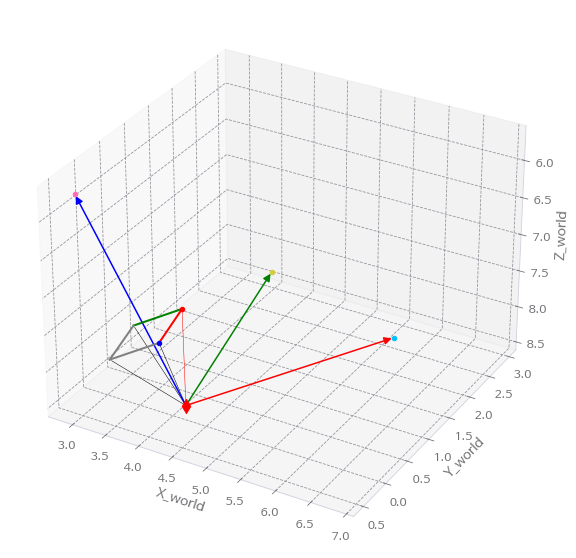

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)

ax.view_init(elev=30, azim=120)

x, y, z = camera.get_camera_center()[target_cam_idx].numpy()

ax.scatter3D(x, y, z, c='red', marker='d', s=100)

for i, ray_d in enumerate(world_bound_ray):
    xs = [x, x+ray_d[0].item()]
    ys = [y, y+ray_d[1].item()]
    zs = [z, z+ray_d[2].item()]

    if i == 0:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="r")
    else:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="black")
    ax.add_artist(a)

left_top = (camera_position + world_bound_ray[0]).numpy()
right_top = (camera_position + world_bound_ray[1]).numpy()
left_bottom = (camera_position + world_bound_ray[2]).numpy()
right_bottom = (camera_position + world_bound_ray[3]).numpy()

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'red')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'green')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

# left-top (= image의 (0,0))
ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
# left-bottom (= image의 (H-1,0))
ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')


R = camera.get_world_to_view_transform().inverse().get_matrix()[target_cam_idx, :3, :3].cpu()
R = R.T

# 카메라의 +x, +y, +z축
xx, xy, xz = (R[:3, 0]*3).numpy()
yx, yy, yz = (R[:3, 1]*3).numpy()
zx, zy, zz = (R[:3, 2]*3).numpy()

# 카메라의 x축 그리기
xs = [x, x+xx]
ys = [y, y+xy]
zs = [z, z+xz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 y축 그리기
xs = [x, x+yx]
ys = [y, y+yy]
zs = [z, z+yz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="g")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 z축 그리기
xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="b")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

In [11]:
ret = ray_sampler.random_sample(10, "center")

sampling_ray_d = ret["ray_d"]
sampling_ray_o = ret["ray_o"]

In [12]:
print(sampling_ray_d.shape)
print(sampling_ray_o.shape)

torch.Size([10, 3])
torch.Size([10, 3])


/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/tmp/ipykernel_168865/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


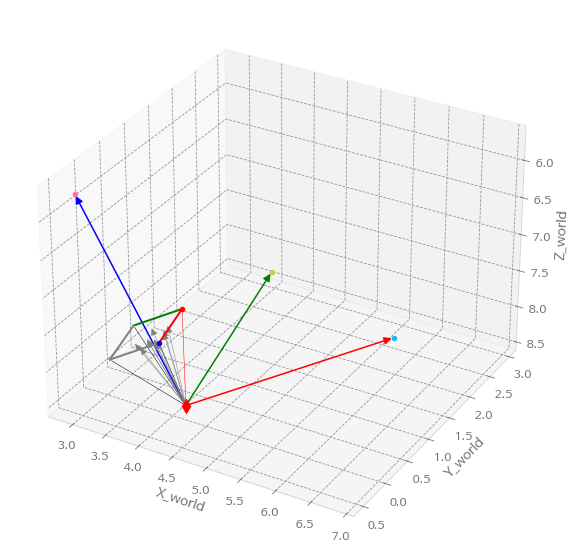

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)

ax.view_init(elev=30, azim=120)

x, y, z = camera.get_camera_center()[target_cam_idx].cpu().numpy()

ax.scatter3D(x, y, z, c='red', marker='d', s=100)


R = camera.get_world_to_view_transform().inverse().get_matrix()[target_cam_idx, :3, :3].cpu()
R = R.T

# 카메라의 +x, +y, +z축
xx, xy, xz = (R[:3, 0]*3).numpy()
yx, yy, yz = (R[:3, 1]*3).numpy()
zx, zy, zz = (R[:3, 2]*3).numpy()

# 카메라의 x축 그리기
xs = [x, x+xx]
ys = [y, y+xy]
zs = [z, z+xz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 y축 그리기
xs = [x, x+yx]
ys = [y, y+yy]
zs = [z, z+yz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="g")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 z축 그리기
xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="b")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])


for i, ray_d in enumerate(world_bound_ray):
    xs = [x, x+ray_d[0].item()]
    ys = [y, y+ray_d[1].item()]
    zs = [z, z+ray_d[2].item()]

    if i == 0:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="r")
    else:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="black")
    ax.add_artist(a)



for i, ray_d in enumerate(sampling_ray_d):
    xs = [x, x+ray_d[0].item()]
    ys = [y, y+ray_d[1].item()]
    zs = [z, z+ray_d[2].item()]

    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="gray")
    ax.add_artist(a)


left_top = (camera_position + world_bound_ray[0]).numpy()
right_top = (camera_position + world_bound_ray[1]).numpy()
left_bottom = (camera_position + world_bound_ray[2]).numpy()
right_bottom = (camera_position + world_bound_ray[3]).numpy()

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'red')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'green')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

# left-top (= image의 (0,0))
ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
# left-bottom (= image의 (H-1,0))
ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')




In [14]:
camera_position = camera_position.cpu()
print(camera_position)

near = np.linalg.norm(camera_position) - 8
far = np.linalg.norm(camera_position) + 8

depth_range =  torch.tensor([near, far], dtype=torch.float32)
print(depth_range)

tensor([-4.1943e+00, -5.3684e-03, -8.4198e+00])
tensor([ 1.4066, 17.4066])


In [15]:
pts, z_vals = sample_along_camera_ray(sampling_ray_o, sampling_ray_d, depth_range,
                            30,
                            inv_uniform=False,
                            det=True)

/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/tmp/ipykernel_168865/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


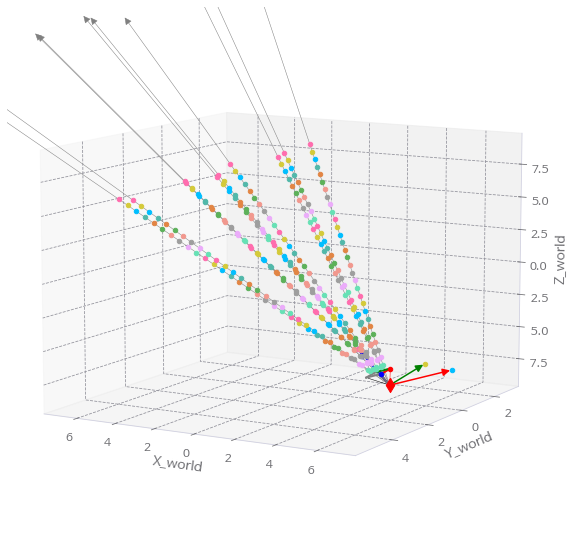

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
# ax.set_zlim(0, 10)

ax.view_init(elev=10, azim=120)

x, y, z = camera_position.numpy()

ax.scatter3D(x, y, z, c='red', marker='d', s=100)

R = camera.get_world_to_view_transform().inverse().get_matrix()[target_cam_idx, :3, :3].cpu()
R = R.T

# 카메라의 +x, +y, +z축
xx, xy, xz = (R[:3, 0]*3).numpy()
yx, yy, yz = (R[:3, 1]*3).numpy()
zx, zy, zz = (R[:3, 2]*3).numpy()

# 카메라의 x축 그리기
xs = [x, x+xx]
ys = [y, y+xy]
zs = [z, z+xz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 y축 그리기
xs = [x, x+yx]
ys = [y, y+yy]
zs = [z, z+yz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="g")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

# 카메라의 z축 그리기
xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=1.5, arrowstyle="-|>", color="b")
ax.add_artist(a)
ax.scatter3D(xs[1], ys[1], zs[1])

for i, ray_d in enumerate(world_bound_ray):
    xs = [x, x+ray_d[0].item()]
    ys = [y, y+ray_d[1].item()]
    zs = [z, z+ray_d[2].item()]

    if i == 0:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="r")
    else:
        a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                        lw=0.5, arrowstyle="-", color="black")
    ax.add_artist(a)


for i, ray_d in enumerate(sampling_ray_d):
    xs = [x, x+ray_d[0].item()*30]
    ys = [y, y+ray_d[1].item()*30]
    zs = [z, z+ray_d[2].item()*30]

    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="gray")
    ax.add_artist(a)
    

for i, pts_per_ray in enumerate(pts):
    for p in pts_per_ray:
        x, y, z = p.cpu()
        ax.scatter3D(p[0].item(), p[1].item(), p[2].item(), cmap="blue")
    


left_top = (camera_position + world_bound_ray[0]).numpy()
right_top = (camera_position + world_bound_ray[1]).numpy()
left_bottom = (camera_position + world_bound_ray[2]).numpy()
right_bottom = (camera_position + world_bound_ray[3]).numpy()

# left
ax.plot(np.linspace(left_top[0], left_bottom[0]), np.linspace(left_top[1], left_bottom[1]), np.linspace(left_top[2], left_bottom[2]), 'red')
# top
ax.plot(np.linspace(left_top[0], right_top[0]), np.linspace(left_top[1], right_top[1]), np.linspace(left_top[2], right_top[2]), 'green')
# right
ax.plot(np.linspace(right_top[0], right_bottom[0]), np.linspace(right_top[1], right_bottom[1]), np.linspace(right_top[2], right_bottom[2]), 'gray')
# bottom
ax.plot(np.linspace(right_bottom[0], left_bottom[0]), np.linspace(right_bottom[1], left_bottom[1]), np.linspace(right_bottom[2], left_bottom[2]), 'gray')

# left-top (= image의 (0,0))
ax.scatter3D(left_top[0], left_top[1], left_top[2], c='red')
# left-bottom (= image의 (H-1,0))
ax.scatter3D(left_bottom[0], left_bottom[1], left_bottom[2], c='blue')


In [17]:
src1_proj_points = camera.transform_points_screen(pts.reshape(-1, 3), image_size=(800, 800))[src1_cam_idx]
src2_proj_points = camera.transform_points_screen(pts.reshape(-1, 3), image_size=(800, 800))[src2_cam_idx]
src3_proj_points = camera.transform_points_screen(pts.reshape(-1, 3), image_size=(800, 800))[src3_cam_idx]

In [18]:
print(src1_proj_points.shape)
print(src2_proj_points.shape)
print(src3_proj_points.shape)

src1_proj_points = src1_proj_points.reshape(10, 30, 3)
src2_proj_points = src2_proj_points.reshape(10, 30, 3)
src3_proj_points = src3_proj_points.reshape(10, 30, 3)

print(src1_proj_points.shape)
print(src2_proj_points.shape)
print(src3_proj_points.shape)


torch.Size([300, 3])
torch.Size([300, 3])
torch.Size([300, 3])
torch.Size([10, 30, 3])
torch.Size([10, 30, 3])
torch.Size([10, 30, 3])


In [19]:
tgt_proj_points = camera.transform_points_screen(pts.reshape(-1, 3), image_size=(800, 800))[target_cam_idx]

print(tgt_proj_points.shape)

tgt_proj_points = tgt_proj_points.reshape(10, 30, 3)

print(tgt_proj_points.shape)

torch.Size([300, 3])
torch.Size([10, 30, 3])


In [20]:
principal_point = (400 - 400*camera.principal_point).cpu()

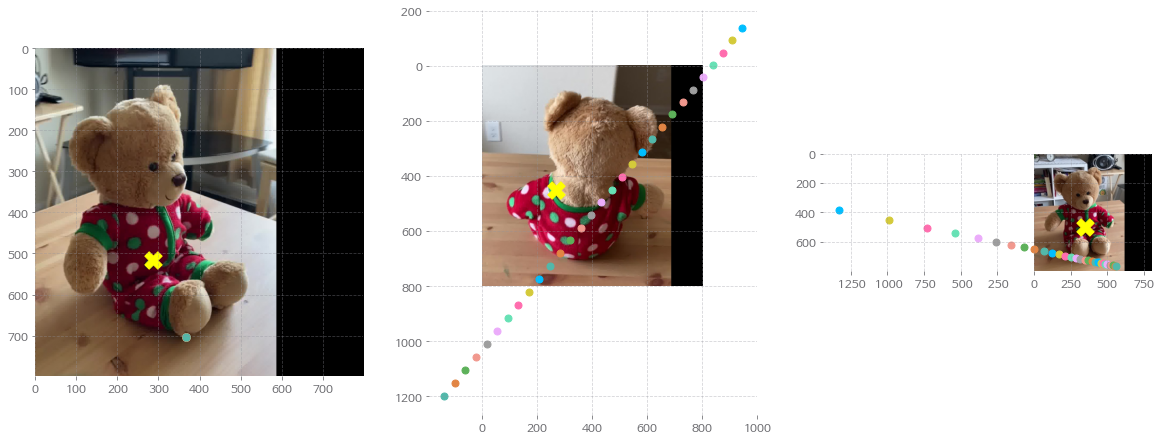

In [21]:
ray_idx = 3


plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)

img = data_frame.image_rgb[target_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.scatter(principal_point[target_cam_idx, 0].item(), principal_point[target_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in tgt_proj_points[ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(1, 3, 2)

img = data_frame.image_rgb[src1_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.scatter(principal_point[src1_cam_idx, 0].item(), principal_point[src1_cam_idx, 1].item(), marker='X', c='yellow', s=300)
for point in src1_proj_points[ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(1, 3, 3)

img = data_frame.image_rgb[src2_cam_idx, :, :].numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.scatter(principal_point[src2_cam_idx, 0].item(), principal_point[src2_cam_idx, 1].item(), marker='X', c='yellow', s=300)

for point in src2_proj_points[ray_idx, :, :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)

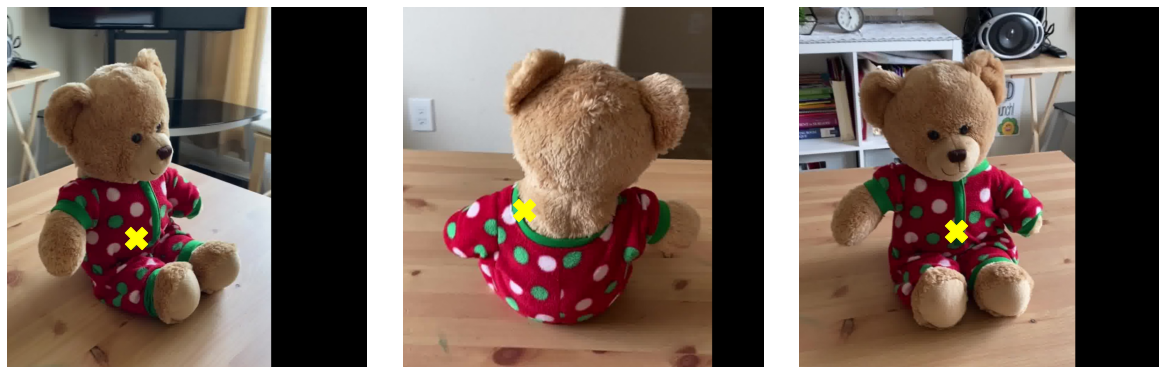

In [22]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0, left=0, right=1, bottom=0, top=1)

# ndc coord --> screen coord
ndc2screen = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(camera, 
                                                                    image_size=(H, W), with_xyflip=True).cpu()
imgs = data_frame.image_rgb.cpu()

for i, idx in enumerate([target_cam_idx, src1_cam_idx, src2_cam_idx]):
    plt.subplot(1, 3, i + 1)
    img = imgs[idx, :, :].numpy().transpose(1, 2, 0)
    plt.imshow(img)

    principal_ndc = camera.principal_point[idx]

    principal_with_z = torch.ones((1, 3))
    principal_with_z[..., :2] = principal_ndc

    principal_screen = ndc2screen.transform_points(principal_with_z)[idx]

    plt.scatter(principal_screen[0][0].item(), principal_screen[0][1].item(), marker='X', c='yellow', s=500)
    
    plt.axis("off")

In [23]:
tmp = torch.tensor([[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]],
                    [[3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5]],
                    [[6, 7, 8], [6, 7, 8], [6, 7, 8], [6, 7, 8], [6, 7, 8]],
                    [[9, 10, 11], [9, 10, 11], [9, 10, 11], [9, 10, 11], [9, 10, 11]],
                    [[12, 13, 14], [12, 13, 14], [12, 13, 14], [12, 13, 14], [12, 13, 14]],
                    [[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]],
                    [[3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5]],
                    [[6, 7, 8], [6, 7, 8], [6, 7, 8], [6, 7, 8], [6, 7, 8]],
                    [[9, 10, 11], [9, 10, 11], [9, 10, 11], [9, 10, 11], [9, 10, 11]],
                    [[12, 13, 14], [12, 13, 14], [12, 13, 14], [12, 13, 14], [12, 13, 14]]])

print(tmp.shape)

torch.Size([10, 5, 3])


In [70]:
tmp_1 = tmp.reshape(-1, 3)
tmp_2 = tmp_1.reshape(10, 5, 3)
tmp_2 == tmp

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
  

In [24]:
from network.feature_network import FeatureNet

In [25]:
device = "cuda"

In [26]:
feature_net = FeatureNet()
feature_net.to(device)

FeatureNet(
  (feature_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [27]:
src1_feature_map = feature_net(data_frame.image_rgb[src1_cam_idx].unsqueeze(0).to(device))
src2_feature_map = feature_net(data_frame.image_rgb[src2_cam_idx].unsqueeze(0).to(device))
src3_feature_map = feature_net(data_frame.image_rgb[src3_cam_idx].unsqueeze(0).to(device))

In [28]:
src1_feature_map.shape

torch.Size([1, 99, 800, 800])

In [29]:
src1_screen_to_ndc = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(camera, image_size=(H, W), with_xyflip=True)[src1_cam_idx]
src2_screen_to_ndc = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(camera, image_size=(H, W), with_xyflip=True)[src2_cam_idx]
src3_screen_to_ndc = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(camera, image_size=(H, W), with_xyflip=True)[src3_cam_idx]

In [30]:
src1_proj_ndc = src1_screen_to_ndc.transform_points(src1_proj_points)
src2_proj_ndc = src2_screen_to_ndc.transform_points(src2_proj_points)
src3_proj_ndc = src3_screen_to_ndc.transform_points(src3_proj_points)

print(src1_proj_ndc.shape)

torch.Size([10, 30, 3])


In [31]:
src1_proj_ndc_xy = src1_proj_ndc[..., :2]
src2_proj_ndc_xy = src2_proj_ndc[..., :2]
src3_proj_ndc_xy = src3_proj_ndc[..., :2]

print(src1_proj_ndc_xy.shape)

torch.Size([10, 30, 2])


In [32]:
src1_grid_idx = src1_proj_ndc_xy.unsqueeze(0)
src2_grid_idx = src2_proj_ndc_xy.unsqueeze(0)
src3_grid_idx = src3_proj_ndc_xy.unsqueeze(0)

In [33]:
import torch.nn.functional as F

In [34]:
src1_sampling_features = F.grid_sample(src1_feature_map, src1_grid_idx, align_corners=False, padding_mode="zeros", mode='bilinear')
src2_sampling_features = F.grid_sample(src2_feature_map, src2_grid_idx, align_corners=False, padding_mode="zeros", mode='bilinear')
src3_sampling_features = F.grid_sample(src3_feature_map, src3_grid_idx, align_corners=False, padding_mode="zeros", mode='bilinear')

In [35]:
src1_sampling_features.shape

torch.Size([1, 99, 10, 30])

In [36]:
src1_sampling_features = src1_sampling_features.permute(0, 2, 3, 1)
src2_sampling_features = src2_sampling_features.permute(0, 2, 3, 1)
src3_sampling_features = src3_sampling_features.permute(0, 2, 3, 1)

print(src1_sampling_features.shape)

torch.Size([1, 10, 30, 99])


In [39]:
ray, sample = (ray_idx, 5)


print(f"index (ndx_x, ndx_y) = {src1_grid_idx[0, ray, sample]}\n")
print(src1_sampling_features[0, ray, sample])

index (ndx_x, ndx_y) = tensor([-0.9166,  0.7863], device='cuda:0')

tensor([ 0.0834,  0.0533, -0.2841, -0.0374,  0.0911,  0.0789,  0.0168,  0.0826,
        -0.0526, -0.0885, -0.2817,  0.1945, -0.3367, -0.0188,  0.1977, -0.2858,
         0.2231, -0.0345, -0.0216,  0.0198, -0.0671,  0.1178, -0.1744, -0.2523,
        -0.0253,  0.0715, -0.2889, -0.0693,  0.2011,  0.4226, -0.0980,  0.1930,
         0.0224,  0.0813, -0.2058,  0.1264,  0.2451,  0.5399,  0.0535, -0.0492,
        -0.1627, -0.1441, -0.2012,  0.0961, -0.0246,  0.2251, -0.0804, -0.1319,
         0.1344, -0.2298,  0.1109,  0.1677, -0.0498,  0.3045, -0.1869, -0.0517,
         0.0592,  0.1722,  0.1011, -0.1671, -0.0853,  0.0310,  0.0902, -0.2715,
        -0.0752,  0.2617,  0.5863, -0.0953, -0.1902, -0.0744, -0.0992,  0.0628,
        -0.1139,  0.0925,  0.0416,  0.1916,  0.0748, -0.1885, -0.0867,  0.0672,
         0.1136,  0.2087,  0.2612,  0.1286,  0.0457,  0.1737, -0.0723,  0.1864,
        -0.3177,  0.0259, -0.0232,  0.0854,  0.0978,

In [40]:
print(400 - (-0.9166 * 400))
print(400 - (0.7863 * 400))

766.64
85.48000000000002


In [41]:
x = src1_proj_points[ray, sample][0].item()
y = src1_proj_points[ray, sample][1].item()
print(f"index (x, y) = {x} = {int(x)}, {y} = {int(y)}\n")

print(src1_feature_map[0, :, int(x), int(y)])

index (x, y) = 765.6798706054688 = 765, 85.37322998046875 = 85

tensor([ 0.0208,  0.0712, -0.3122,  0.0516,  0.0377,  0.0991, -0.0469,  0.0472,
        -0.0618, -0.1328, -0.2345,  0.1448, -0.3462, -0.0323,  0.1804, -0.2412,
         0.1735, -0.0321, -0.0500, -0.0350, -0.0750,  0.2040, -0.1317, -0.2409,
        -0.0089,  0.0758, -0.3297, -0.1609,  0.2390,  0.4207, -0.0814,  0.1762,
        -0.0740,  0.1198, -0.1011,  0.2448,  0.3806,  0.3526,  0.1254,  0.1767,
        -0.1192, -0.0825, -0.2101, -0.1771, -0.0344,  0.0843, -0.1357, -0.2305,
        -0.0176, -0.2407,  0.0370,  0.1982,  0.0387,  0.3146, -0.1515, -0.0216,
         0.0989, -0.0145, -0.0743, -0.1216,  0.1840, -0.1991,  0.1812, -0.2409,
        -0.0496, -0.1763,  0.6413, -0.1944, -0.0087, -0.1649, -0.0435, -0.0847,
         0.0183,  0.0540, -0.0444,  0.1819, -0.0704,  0.1002,  0.0489,  0.0134,
         0.0775,  0.1876,  0.2269,  0.0691, -0.0697,  0.2215, -0.0446,  0.0032,
        -0.3789,  0.0980,  0.0410,  0.0980,  0.1069, -0.

In [42]:
from network.model import NerFormer

In [43]:
net = NerFormer(d_z=99)

In [44]:
net.to(device)

NerFormer(
  (linear_1): Linear(in_features=99, out_features=80, bias=False)
  (TE_1): Sequential(
    (0): TransformerEncoder(
      (multi_head_att): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=80, out_features=80, bias=True)
      )
      (Q_weights): Linear(in_features=80, out_features=80, bias=True)
      (K_weights): Linear(in_features=80, out_features=80, bias=True)
      (V_weights): Linear(in_features=80, out_features=80, bias=True)
      (dropout_1): Dropout(p=0.1, inplace=False)
      (dropout_2): Dropout(p=0.1, inplace=False)
      (layer_norm_1): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (two_layer_MLP): Sequential(
        (0): Linear(in_features=80, out_features=80, bias=True)
        (1): ReLU()
        (2): Linear(in_features=80, out_features=80, bias=True)
      )
    )
    (1): TransformerEncoder(
      (multi_head_att): MultiheadAttention(
        (out

In [45]:
src1_sampling_features.shape

torch.Size([1, 10, 30, 99])

In [46]:
total_sampling_feature = torch.stack([src1_sampling_features, src2_sampling_features, src3_sampling_features], dim=3)

In [47]:
total_sampling_feature.shape

torch.Size([1, 10, 30, 3, 99])

In [48]:
total_sampling_feature = total_sampling_feature.squeeze(0)

total_sampling_feature.shape

# [rays(=batch), num_samples, num_src, d_z]

torch.Size([10, 30, 3, 99])

In [49]:
output = net(total_sampling_feature)

ValueError: too many values to unpack (expected 3)

In [167]:
import torch.nn as nn

In [170]:
first = nn.Linear(99, 80, bias=False).to(device)

In [177]:
total_sampling_feature.shape

torch.Size([10, 30, 3, 99])

In [179]:
output = first(total_sampling_feature)

In [180]:
output.shape

torch.Size([10, 30, 3, 80])